# VolSense Notebook 03 — Model Inference, Forecasting & Trader Analytics

## 1️⃣ Notebook Overview
This notebook demonstrates how to **run forecasts, visualize predictions, and interpret trader analytics** using the trained VolSense models.

We’ll use the two **flagship models** that ship with the repository — **v109** and **v507** — and explore the end-to-end inference pipeline:

- Loading pretrained models using `volsense_inference.forecast_engine.Forecast`
- Generating volatility forecasts for single or multiple tickers
- Visualizing realized vs predicted volatility
- Understanding trader-facing analytics and signals from `analytics.py` and `signal_engine.py`
- Running forecasts directly via the CLI (`volsense-forecast`)

## 2️⃣ The Flagship Models: v109 and v507

### **v109 — Multi-Validation Stable Model**
- Trained on **109 tickers** spanning equities, ETFs, commodities, and macro indices.
- **Validated across three distinct regimes**:
  - **2023–2025**: Current market dynamics
  - **2020–2021**: Pandemic volatility and macro uncertainty
  - **2013–2014**: Calm, low-volatility regime
- Achieved a **maximum difference of only 8%** in both MSE and MAE across validation slices.
- This made `v109` the **baseline stable model**, ensuring robust generalization across market environments.

### **v509 — Broad-Market Expansion Model**
- Built on a **similar architecture** to `v109`, but expanded to include **every major S&P 500 sector**, plus key ETFs, financials, and energy tickers.
- Focused on **cross-sector learning**, allowing the model to capture volatility transfer effects between different sectors (e.g., Tech vs Energy).
- Trained with **extended feature sets** and **more varied data**, making it the preferred model for **cross-sectional volatility forecasting**.
- `v507` is the **default model** for `volsense_inference` and all CLI-based forecasting.

## 3️⃣ Imports & Setup

In [1]:
from volsense_inference.forecast_engine import Forecast
from volsense_inference.analytics import Analytics

## 4️⃣ Load a Trained Model
You can initialize a model using the **Forecast** class, which automatically loads all required assets (model weights, scalers, tickers, feature metadata).

In [6]:
# Initialize with a pre-trained model version
fcast = Forecast(model_version="v109", checkpoints_dir="models")

🚀 Initializing VolSense.Forecast (model=v109)
✔ Window=40, Horizons=[1, 5, 10]


In [3]:
fcast2 = Forecast(model_version="v507", checkpoints_dir="models")

🚀 Initializing VolSense.Forecast (model=v507)
✔ Window=40, Horizons=[1, 5, 10]


**What happens under the hood:**
- The model and its metadata are loaded using `model_loader.py`.
- The metadata includes window size, forecast horizons, feature list, and ticker-to-ID mappings.
- Forecast uses the same preprocessing and scaling logic used during training.

## 5️⃣ Run Forecasts

In [3]:
# Run forecasts for one or more tickers
preds = fcast.run(["AAPL", "MSFT", "TSLA"])
print(preds.head())

NameError: name 'fcast' is not defined

This automatically:
1. Fetches the most recent OHLCV data for the tickers using `multi_fetch.py`.
2. Computes **returns**, **realized volatility**, and **engineered features** using the same pipeline as training.
3. Runs multi-horizon predictions (1D, 5D, 10D).
4. Attaches realized volatility to forecasts for direct comparison.

## 6️⃣ Visualize Forecasts

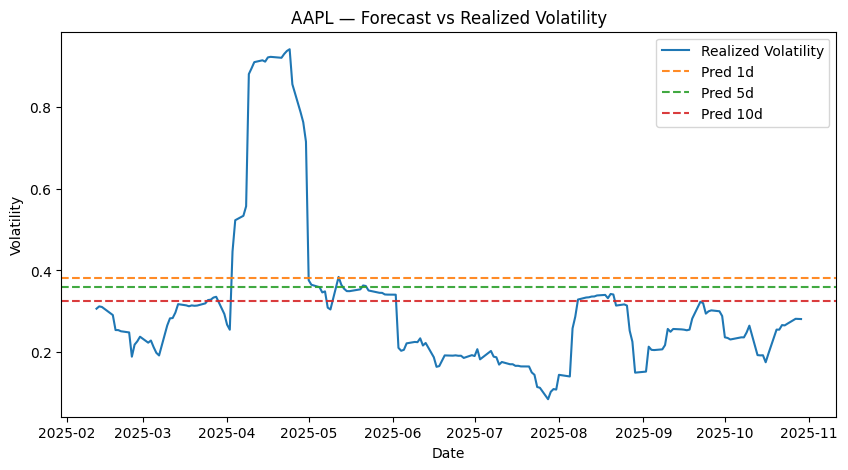

In [8]:
# Plot realized vs predicted volatility
fcast.plot("AAPL")


**Plot interpretation:**
- The blue line: realized (historical) volatility.
- Dashed lines: predicted volatility for each horizon.
- This allows traders to see how near-term and medium-term forecasts diverge, signaling expected volatility expansion or contraction.

## 7️⃣ Trader-Facing Analytics: Snapshot Metrics

VolSense integrates a lightweight **Analytics** layer that summarizes predictions into actionable trader insights.

In [5]:
# Initialize analytics
analytics = Analytics(preds)
df_summary = analytics.summary("pred_vol_5")
display(df_summary.head())

,ticker,realized_vol,forecast_vol,f/r_ratio,zscore,vol_regime
0,TSLA,0.483765,0.595932,1.231862,1.682488,High Vol
1,AAPL,0.281945,0.348412,1.235747,0.277857,Normal
2,MSFT,0.132638,0.262023,1.975477,-0.212386,Low Vol


**Columns explained:**
- **forecast_vol**: 5-day ahead forecasted volatility.
- **f/r_ratio**: forecast-to-realized ratio (>1 → rising volatility).
- **zscore**: cross-sectional z-score relative to other tickers on the same day.
- **vol_regime**: classified as *Low Vol*, *Normal*, or *High Vol* based on quantiles of realized volatility.

## 8️⃣ Textual Signal Descriptions
For qualitative insights, traders can call `describe()` for human-readable summaries:

In [6]:
print(analytics.describe("AAPL", horizon="pred_vol_5"))

AAPL: 5-day vol ↑ rising (+0.28σ vs peers), regime: Normal.


This makes it intuitive for traders to interpret raw volatility numbers in the context of the broader market.

## 9️⃣ Visualization of Forecast vs. Today's volatility

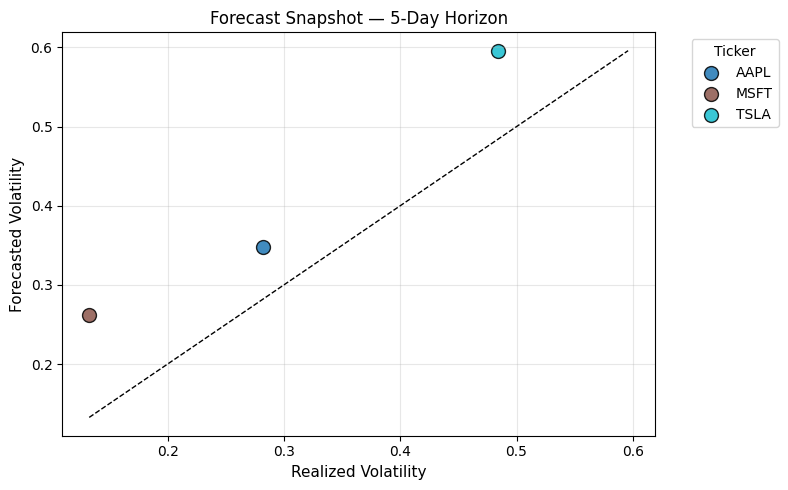

In [7]:
# Cross-sectional snapshot visualization
analytics.plot("pred_vol_5", show=True)

**Interpretation:**
- Each point represents a ticker.
- X-axis: realized volatility which is today's volatility; Y-axis: predicted volatility 5 days ahead.
- The 45° reference line marks continuing constatnt volatility.
- Points above the line → model predicting higher volatility (bullish vol regime).

---

## 🔟 Command-Line Forecasting (CLI)
The same inference process can be executed entirely from the terminal using the **CLI utility**.

**Example:**
```bash
python -m volsense_inference.forecast \
  --tickers AAPL MSFT TSLA \
  --model v507 \
  --horizon 5 \
  --plot
```

**CLI flags:**
| Flag | Description |
|------|--------------|
| `--tickers` | One or more tickers separated by space |
| `--model` | Model version (e.g. v109, v507) |
| `--horizon` | Forecast horizon to display (default 10) |
| `--plot` | If set, produces visualization(s) |
| `--save` | Optional CSV output path |

## 1️⃣3️⃣ Why v109 and v507 Were Chosen for Release
| Model | Strength | Reason for Release |
|--------|-----------|--------------------|
| **v109** | Stability across market regimes | Validated across 3 temporal regimes with minimal variance in errors (≤8%). Demonstrates strong temporal generalization. |
| **v507** | Breadth & sectoral coverage | Incorporates all major S&P500 sectors, ETFs, and diversified tickers. Performs strongly cross-sectionally and generalizes to unseen sectors. |

Together, they form a **two-tiered deployment suite**:
- `v109` → robust baseline model for research and backtesting.
- `v507` → flagship model for real-world cross-asset volatility forecasting.

---

## 1️⃣4️⃣ Conclusion
VolSense integrates deep learning, econometric modeling, and trader analytics into a single forecasting pipeline.

By using the `Forecast`, `Analytics`, and APIs (or the CLI tools), traders and researchers can:
- Generate forecasts for any combination of assets.
- Compare model predictions against realized volatility.
- Quantify cross-asset volatility regimes.

Next step → Move to **04_signal_engine_and_dashboard.ipynb** to explore trading signals using `signal_engine.py` and live Streamlit integration and visualization of forecast signals.